**Import Library**

In [1]:
import re
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from underthesea import word_tokenize
from collections import Counter
import fasttext

**Read data & Visualize**

In [2]:
dt = pd.read_csv("data/tvpl_data.csv", encoding="utf-8")
dt.head()

,Loại,Thực thể tham chiếu,Quan hệ,Nội dung Trước thực thể được tham chiếu,Thực thể được tham chiếu,Nội dung Sau thực thể được tham chiếu
0,HP,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,CC,Căn_cứ,Hiến_pháp nước Cộng_hoà xã_hội chủ_nghĩa Việt_nam,NaN
1,LT,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Tổ_chức kinh_tế theo quy_định của,Luật Đầu_tư,", trừ trường_hợp quy_định tại khoản 7 Điều này"
2,LT,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Ủy_ban nhân_dân cấp xã có công_chức làm công_t...,"Luật Cán_bộ , công_chức",NaN
3,QĐ,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,Quyết_định của cơ_quan nhà_nước có thẩm_quyền ...,Quyết_định thi_hành án,của cơ_quan
4,QĐ,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,NaN,Quyết_định thi_hành án,đã được thi_hành


In [3]:
A = "Thực thể tham chiếu"
Label = "Quan hệ"
B = "Thực thể được tham chiếu"
Before_B = "Nội dung Trước thực thể được tham chiếu"
After_B = "Nội dung Sau thực thể được tham chiếu"

data_Clean = dt[[A,Label,Before_B,B,After_B]].copy()
data_Clean[Label] = dt[Label].fillna('None')
data_Clean[[A, B]].dropna()
data_Clean.info()


data_Clean['Quan hệ'].unique()
data_Clean.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148558 entries, 0 to 148557
Data columns (total 5 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   Thực thể tham chiếu                      148558 non-null  object
 1   Quan hệ                                  148558 non-null  object
 2   Nội dung Trước thực thể được tham chiếu  110690 non-null  object
 3   Thực thể được tham chiếu                 148558 non-null  object
 4   Nội dung Sau thực thể được tham chiếu    94056 non-null   object
dtypes: object(5)
memory usage: 5.7+ MB


,Thực thể tham chiếu,Quan hệ,Nội dung Trước thực thể được tham chiếu,Thực thể được tham chiếu,Nội dung Sau thực thể được tham chiếu
0,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,CC,Căn_cứ,Hiến_pháp nước Cộng_hoà xã_hội chủ_nghĩa Việt_nam,NaN
1,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Tổ_chức kinh_tế theo quy_định của,Luật Đầu_tư,", trừ trường_hợp quy_định tại khoản 7 Điều này"
2,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Ủy_ban nhân_dân cấp xã có công_chức làm công_t...,"Luật Cán_bộ , công_chức",NaN
3,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,Quyết_định của cơ_quan nhà_nước có thẩm_quyền ...,Quyết_định thi_hành án,của cơ_quan
4,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,NaN,Quyết_định thi_hành án,đã được thi_hành
5,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,Quyết_định của cơ_quan nhà_nước có thẩm_quyền ...,Quyết_định thi_hành án,của cơ_quan
6,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,NaN,Quyết_định thi_hành án,đã được thi_hành
7,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Trường_hợp chủ đầu_tư chuyển_nhượng quyền sử_d...,Luật Kinh_doanh bất_động_sản,","
8,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,NaN,Luật Nhà ở,NaN
9,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Trường_hợp được Nhà_nước cho thuê đất trả tiền...,Luật Kinh_doanh bất_động_sản,NaN


In [4]:
groups = data_Clean.groupby(by=Label).count()[A]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups,
    marker_color='cadetblue',
    width=[0.4, 0.4]))
fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

**Preprocessing**

In [5]:
def load_dicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Chuyển đổi mã kí tự 1252 sang UTF-8
def covert_unicode(text):
    dicchar = load_dicchar()
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], text)

def text_preprocessing(document):
    # Chuyển đổi mã kí tự 1252 sang UTF-8
    document['Text'] = document['Text'].apply(covert_unicode)
    # Đưa về dạng chữ thường
    document['Text'] = document['Text'].str.lower()
    # xóa các ký tự không cần thiết
    document['Text'] = document['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
    document = document['Text'].apply(lambda y: re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',str(y)))
    return document

In [5]:
dt_clean =  data_Clean.loc[data_Clean[Label].isin(groups.index)].reset_index(drop=True)
dt_clean.info()
dt_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148558 entries, 0 to 148557
Data columns (total 5 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   Thực thể tham chiếu                      148558 non-null  object
 1   Quan hệ                                  148558 non-null  object
 2   Nội dung Trước thực thể được tham chiếu  110690 non-null  object
 3   Thực thể được tham chiếu                 148558 non-null  object
 4   Nội dung Sau thực thể được tham chiếu    94056 non-null   object
dtypes: object(5)
memory usage: 5.7+ MB


,Thực thể tham chiếu,Quan hệ,Nội dung Trước thực thể được tham chiếu,Thực thể được tham chiếu,Nội dung Sau thực thể được tham chiếu
0,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,CC,Căn_cứ,Hiến_pháp nước Cộng_hoà xã_hội chủ_nghĩa Việt_nam,NaN
1,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Tổ_chức kinh_tế theo quy_định của,Luật Đầu_tư,", trừ trường_hợp quy_định tại khoản 7 Điều này"
2,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Ủy_ban nhân_dân cấp xã có công_chức làm công_t...,"Luật Cán_bộ , công_chức",NaN
3,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,Quyết_định của cơ_quan nhà_nước có thẩm_quyền ...,Quyết_định thi_hành án,của cơ_quan
4,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,NaN,Quyết_định thi_hành án,đã được thi_hành


In [6]:
dt_clean['Text'] = dt_clean.apply(lambda d: f'{d[A]} {d[Before_B]} {d[B]} {d[After_B]}'.strip(), axis=1)

dt_clean.head()

,Thực thể tham chiếu,Quan hệ,Nội dung Trước thực thể được tham chiếu,Thực thể được tham chiếu,Nội dung Sau thực thể được tham chiếu,Text
0,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,CC,Căn_cứ,Hiến_pháp nước Cộng_hoà xã_hội chủ_nghĩa Việt_nam,NaN,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...
1,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Tổ_chức kinh_tế theo quy_định của,Luật Đầu_tư,", trừ trường_hợp quy_định tại khoản 7 Điều này",Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...
2,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,Ủy_ban nhân_dân cấp xã có công_chức làm công_t...,"Luật Cán_bộ , công_chức",NaN,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...
3,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,Quyết_định của cơ_quan nhà_nước có thẩm_quyền ...,Quyết_định thi_hành án,của cơ_quan,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...
4,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None,NaN,Quyết_định thi_hành án,đã được thi_hành,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...


In [8]:
dt_preprocess =  dt_clean[['Text', 'Quan hệ']].copy()
dt_preprocess.head()


,Text,Quan hệ
0,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,CC
1,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC
2,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC
3,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None
4,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,None


In [9]:
dt_preprocess['Text'] = text_preprocessing(dt_preprocess)
dt_preprocess.head()

,Text,Quan hệ
0,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,CC
1,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,DC
2,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,DC
3,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,None
4,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,None


**Text Length**

In [10]:
def check_length(data):
    min_length = float('inf')
    max_length = 0
    total_length = 0
    count = 0
    length_counts = {}

    for text in data:
        length = len(text)

        # Update minimum length
        if length < min_length:
            min_length = length
            m = count

        # Update maximum length
        if length > max_length:
            max_length = length

        # Update total length for average calculation
        total_length += length

        # Update length counts for mode calculation
        if length in length_counts:
            length_counts[length] += 1
        else:
            length_counts[length] = 1

        count += 1

    average_length = round(total_length / count)
    mode_length = max(length_counts, key=length_counts.get)


    count_mode = 0
    for i in data:
        if len(i) == mode_length:
            count_mode = count_mode + 1
    count_avg = 0
    for j in data:
        if len(j) == average_length:
            count_avg = count_avg + 1


    print("Minimum length:", min_length)
    print("Maximum length:", max_length)
    print("Average length:", average_length)
    print("Mode length:", mode_length)
    print("Count Mode length:", count_mode)
    print("Count Avg length:", count_avg)


check_length(dt_preprocess['Text'])

Minimum length: 76
Maximum length: 1182
Average length: 215
Mode length: 123
Count Mode length: 2643
Count Avg length: 933


In [11]:
max_length = 250  # Chiều dài tối đa của câu lấy theo độ dài trung bình của toàn bộ tập dữ liệu

**Tokenization**

In [12]:
def tokenization(data):
    Text_col = data
    tokenizer = Tokenizer(split=' ')
    tokenizer.fit_on_texts(Text_col)
    words_to_index = tokenizer.word_index
    vocab_size = len(words_to_index) + 1

    # chuyển đổi dữ liệu văn bản thành các chuỗi số
    tokenizer_seq = tokenizer.texts_to_sequences(Text_col)

    # Đảm bảo mỗi sequece có cùng độ dài
    # 'post' có nghĩa là thêm padding vào cuối mỗi sequence
    # 'pre' có nghĩa là thêm padding vào đầu mỗi sequence
    tokenizer_pad = pad_sequences(tokenizer_seq, padding='pre', truncating='post', maxlen=max_length)

    return tokenizer_pad, vocab_size, words_to_index

In [13]:
# Tách từ
data_tokenizer = dt_preprocess.copy()
data_tokenizer['Text'] = data_tokenizer['Text'].apply(word_tokenize)

data_tokenizer.info()
data_tokenizer.head()


data_tokenizer_pad, vocab_size, words_to_index = tokenization(data_tokenizer['Text'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148558 entries, 0 to 148557
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     148558 non-null  object
 1   Quan hệ  148558 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [14]:
print(data_tokenizer_pad)

[[   0    0    0 ...  440   68   14]
 [   0    0    0 ...  106   13   49]
 [   0    0    0 ... 3567  252   14]
 ...
 [   0    0    0 ...  197    1   14]
 [   0    0    0 ... 3882  228   14]
 [   0    0    0 ...  887   46 2602]]


**Embedding**

In [15]:
with open('model/fasttext/tvpl_text.txt', 'w', encoding="utf-8") as file:
    # Write content to the
    for i in dt_preprocess['Text']:
        file.write(i+"\n")

In [16]:
model_fasttext = fasttext.train_unsupervised('model/fasttext/tvpl_text.txt', maxn=0, dim=100)
model_fasttext.save_model('model/fasttext/fasttext_100d_tvpl.bin')

In [17]:
all_text = ' '.join(dt_preprocess['Text'])

# Split the text into individual words
words = all_text.split()

# Count the frequency of each word
word_counts = Counter(words)

# Find the word with the highest frequency
most_common_word, frequency = word_counts.most_common(1)[0]

print("Most common word:", most_common_word)
print("Frequency:", frequency)

Most common word: của
Frequency: 270213


In [18]:
embedding_dim = 100  # Kích thước nhúng


ft = fasttext.load_model('model/fasttext/fasttext_100d_tvpl.bin')
embed_vector_size = ft.get_word_vector('của').shape[0]

embed_vector_matrix = np.zeros((vocab_size, embed_vector_size))

for word, i in words_to_index.items():
    embedding_vector = ft.get_word_vector(word)
    if any(embedding_vector):
        embed_vector_matrix[i] = embedding_vector
    else:
        embed_vector_matrix[i] = np.random.uniform(low=-1, high=1, size= embed_vector_size)

print(f"Max length | input_length      = {max_length}")
print(f"input_dim  | vocab_size        = {vocab_size}")
print(f"output_dim | embed_vector_size = {embed_vector_size}")
print(f"weights = {embed_vector_matrix.shape}")

embedding = Embedding(input_dim=vocab_size, output_dim=embed_vector_size,
                      input_length=max_length, weights=[embed_vector_matrix], trainable=False)

Max length | input_length      = 250
input_dim  | vocab_size        = 25673
output_dim | embed_vector_size = 100
weights = (25673, 100)



**Create Model**

In [19]:
classes = data_tokenizer['Quan hệ'].nunique()
print(f"Number labels = {classes}")

def create_model():
    lstm_units =250  # Số đơn vị LSTM
    dropout_val = 0.2
    recurrent_dropout = 0.1

    model = Sequential()
    model.add(embedding)
    model.add(LSTM(lstm_units, return_sequences=True, dropout=dropout_val,recurrent_dropout=recurrent_dropout))
    model.add(LSTM(lstm_units, return_sequences=True, dropout=dropout_val,recurrent_dropout=recurrent_dropout))
    model.add(LSTM(lstm_units, return_sequences=True, dropout=dropout_val,recurrent_dropout=recurrent_dropout))
    model.add(SeqSelfAttention())
    model.add(Flatten())
    model.add(Dense(classes, activation="softmax"))

    # Model compiling
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Number labels = 7


In [20]:
# Chia dataset thành tập training thành train_val và test
X = data_tokenizer_pad
y = data_tokenizer['Quan hệ']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y.values, test_size=0.2, random_state=40)

In [21]:
# encode label
label_encoder = LabelEncoder()
label_encoder.fit(data_tokenizer["Quan hệ"].values)
print('\nLabels:',list(label_encoder.classes_), '\n')
y_train_val = label_encoder.transform(y_train_val)
y_test = label_encoder.transform(y_test)

# Chia train_val thành train và validation
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=40)

print("Size Train: ",X_train.shape, y_train.shape)
print("Size Test: ",X_test.shape, y_test.shape)
print("Size Validation: ",X_val.shape, y_val.shape)


Labels: ['BTT', 'CC', 'DC', 'DHD', 'DSD', 'HHL', 'None'] 

Size Train:  (89134, 250) (89134,)
Size Test:  (29712, 250) (29712,)
Size Validation:  (29712, 250) (29712,)


**Run**

In [22]:
model = create_model()
batchSize = 128
epoch = 20
model.summary()


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning:

The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          2567300   
                                                                 
 lstm (LSTM)                 (None, 250, 250)          351000    
                                                                 
 lstm_1 (LSTM)               (None, 250, 250)          501000    
                                                                 
 lstm_2 (LSTM)               (None, 250, 250)          501000    
                                                                 
 seq_self_attention (SeqSel  (None, 250, 250)          16065     
 fAttention)                                                     
                                                                 
 flatten (Flatten)           (None, 62500)             0         
                                                       

In [23]:
# Ghi lại thời điểm bắt đầu
start_time = time.time()
checkpoint_path = "".join(['checkpoint','vbpl_ft',"/cp.ckpt"])
checkpoint_dir = os.path.dirname(checkpoint_path)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
checkpointing = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
lstm_model_history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epoch, callbacks=[earlystopping,checkpointing], validation_data=(X_val, y_val))

# Tính thời gian đã trôi qua
training_time = round(time.time() - start_time, 2)

Epoch 1/20


697/697 [==============================] - ETA: 0s - loss: 0.6067 - accuracy: 0.7754  
Epoch 1: saving model to checkpointvbpl_ft\cp.ckpt
697/697 [==============================] - 58993s 85s/step - loss: 0.6067 - accuracy: 0.7754 - val_loss: 0.4105 - val_accuracy: 0.8575
Epoch 2/20
697/697 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.8587  
Epoch 2: saving model to checkpointvbpl_ft\cp.ckpt
697/697 [==============================] - 67593s 97s/step - loss: 0.3962 - accuracy: 0.8587 - val_loss: 0.3625 - val_accuracy: 0.8675
Epoch 3/20
697/697 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8780  
Epoch 3: saving model to checkpointvbpl_ft\cp.ckpt
697/697 [==============================] - 68685s 99s/step - loss: 0.3382 - accuracy: 0.8780 - val_loss: 0.3124 - val_accuracy: 0.8825
Epoch 4/20
697/697 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.8879  
Epoch 4: saving model to checkpointvbpl_ft\cp.ck

**Save Model**

In [24]:
# thu tu cac chi so: maxLength_Batch_epochs_dropout_recurrentDropout
path = f"model/model_tvpl_{max_length}_250lstmunits_{batchSize}_{epoch}_{0.2}_{0.1}_{training_time}.h5"

print(path)
model.save(path)

model/model_tvpl_250_250lstmunits_128_20_0.2_0.1_1121956.82.h5


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



**Prediction**

In [25]:
# Predictions on the Test Set
score = model.evaluate(X_test, y_test)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

929/929 [==============================] - 4850s 5s/step - loss: 0.2338 - accuracy: 0.9202
Test Score: 0.2338390052318573
Test Accuracy: 0.9201669096946716


In [26]:
start = None
end = None

# Phân loại 
y_pred = model.predict(X_test[start:end])
# Mã hóa label
y_pred_original = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_original = label_encoder.inverse_transform(y_test[start:end])

# In ra kết quả phân loại
print(f"Kết quả thực tế: {y_test_original}")
print(f"Kết quả mô hình phân loại: {y_pred_original} - {y_pred_original == y_test_original}")

929/929 [==============================] - 4877s 5s/step
Kết quả thực tế: ['CC' 'None' 'DC' ... 'None' 'DSD' 'DC']
Kết quả mô hình phân loại: ['CC' 'None' 'DC' ... 'None' 'DSD' 'DC'] - [ True  True  True ...  True  True  True]


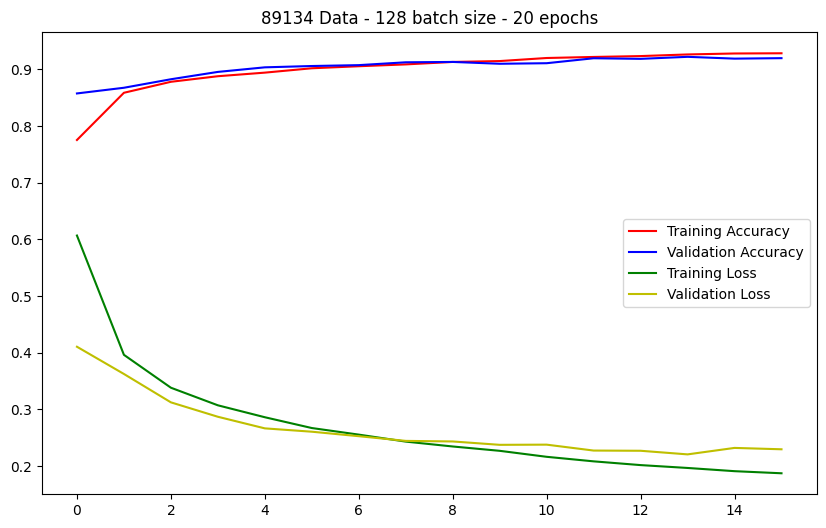

In [27]:
def plot_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(10,6))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')

    plt.title(f'{X_train.shape[0]} Data - {batchSize} batch size - {epoch} epochs')
    plt.legend(loc=0)
    plt.savefig(f'images/tvpl_img_{max_length}_250lstmunits_{batchSize}_{epoch}_0.4_0.1.png')
    plt.show()


plot_graph(lstm_model_history)

In [28]:
# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_test_original, y_pred_original, average=None)
recall_per_class = recall_score(y_test_original, y_pred_original, average=None)
f1_per_class = f1_score(y_test_original, y_pred_original, average=None)

# Calculate macro-average precision, recall, and F1 score
macro_precision = round(np.mean(precision_per_class),3)
macro_recall = round(np.mean(recall_per_class),3)
macro_f1 = round(np.mean(f1_per_class),3)

# Create a DataFrame for the table
metrics_table_per_class = pd.DataFrame({
    'Class': np.unique(y_test_original),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})

# Print the table per class
print("Metrics Table per Class:")
print(metrics_table_per_class)

# Print macro-average metrics
print("\nMacro-Average Metrics:")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1 Score: {macro_f1}")

Metrics Table per Class:
  Class  Precision    Recall  F1 Score
0   BTT   0.711111  0.351648  0.470588
1    CC   0.962135  0.971757  0.966922
2    DC   0.923446  0.939874  0.931587
3   DHD   0.671937  0.422886  0.519084
4   DSD   0.777893  0.794304  0.786013
5   HHL   0.901961  0.721003  0.801394
6  None   0.900112  0.891148  0.895607

Macro-Average Metrics:
Macro Precision: 0.836
Macro Recall: 0.728
Macro F1 Score: 0.767


**Confusion Matrix**

In [29]:
# Tìm tất cả các nhãn duy nhất
labels = np.unique(np.concatenate((y_test_original, y_pred_original)))

# Tạo ma trận confusion
confusion = confusion_matrix(y_test_original, y_pred_original, labels=labels)

print("Ma trận confusion:")
print(confusion)

Ma trận confusion:
[[   32     2    11     8    20     1    17]
 [    0  7191   131    27    24     0    27]
 [    0   127 12521    35    97     7   535]
 [    3   100   108   170    17     0     4]
 [    5    10   109     3   753     0    68]
 [    0     0    18     1     6   230    64]
 [    5    44   661     9    51    17  6443]]
